In [2]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
import os


%matplotlib widget

In [3]:
m_l=0.5
t_total = 0.1
leg_max = 0.1

tau_max=0.05
omega_max=3000
nsteps = 20
t = t_total/nsteps #should be named dt

''' Function for one analytical step '''
def get_Fstep():
    k = SX.sym('k')
    X0 = SX.sym('X0', 5) #states: x_a, x_l, v_l, T1_last, T2_last
    x_a0 = X0[0]
    x_l0 = X0[1]
    v_l0 = X0[2]
    T1_0 = X0[3]
    T2_0 = X0[4]
    T = SX.sym('T', 2) #transmission ratio for this step
    T1 = T[0]
    T2 = T[1]
    x_l0 = T2*(x_a0*(T1-T1_0) + x_l0/T2_0) #solve for x_l to make spring compression continuous

    x0 = 1/T2
    x1 = T2**2
    x2 = omega_max**2
    x3 = x1*x2
    x4 = k**2
    x5 = m_l**2
    x6 = T1**4*x5
    x7 = x4*x6
    x9 = 1/tau_max
    x10 = (1/2)*x9
    x12 = T1**2
    x13 = omega_max*t
    x14 = k*x10*x12*x13
    x15 = exp(x14)
    x16 = tau_max*x15
    x17 = x16*x_a0
    x18 = T1*omega_max
    x19 = T2*m_l*v_l0*x18
    x20 = m_l*x12
    x21 = x20*x3
    x22 = k*m_l
    x23 = 2*tau_max
    x24 = x23*x_l0
    x25 = x12*x22
    x26 = x23*x_a0
    x27 = T2*omega_max
    x28 = T2**3
    x29 = omega_max**3
    x30 = T1**3
    x32 = exp(-x14)
    x33 = x32*x9
    x34 = x1*x18
    x35 = T2*v_l0 - x34
    x36 = 2*k
    x37 = T1*T2
    x38 = omega_max*x1
    x39 = 2*v_l0*x25*x38
    x40 = x2*x28
    x41 = x22*x30*x40
    x42 = 2*x41
    x43 = tau_max*x36
    x44 = -x37*x43*x_a0 + x43*x_l0
    r = 4*k*m_l*tau_max**2 - x3*x7
    R_ad_re = if_else(r>0, sqrt(r), 0)
    R_ad_im = if_else(r>0, 0, sqrt(-r))
    x11_re = t*x0*x10*R_ad_re/m_l
    x11_im = t*x0*x10*R_ad_im/m_l
    C_os = cos(x11_re)*cosh(x11_im)
    S_in_re = sin(x11_re)*cosh(x11_im)
    S_in_im = cos(x11_re)*sinh(x11_im)
    SdR = (S_in_re*R_ad_re + S_in_im*R_ad_im) / (R_ad_re**2 + R_ad_im**2) # S_in/R_ad should be purely real (aka x31)
    SmR = S_in_re*R_ad_re - S_in_im*R_ad_im  # S_in*R_ad should be purely real
    x_a = x33*(C_os*(-x19 + x21) + x13*x16 + x15*x19 - x15*x21 + x17 + SdR*(-k*v_l0*x3*x30*x5 + k*x28*x29*x6 + x18*x22*x24 - x25*x26*x27))
    x_l = (1/2)*x33*(C_os*(-x39 + x42 + x44) + SmR*x35 + T2*t*x16*x18*x36 + x15*x39 - x15*x42 + x17*x36*x37 + SdR*(T1**5*T2**4*x29*x4*x5 - m_l*x26*x30*x38*x4 - v_l0*x40*x7 + x20*x24*x27*x4))/k
    v_l = x0*x32*(C_os*x35 + x15*x34 + SdR*(k*m_l*omega_max*v_l0*x1*x12 - x41 - x44))
    X_new = SX.sym('X_new', 5)
    X_new[0] = x_a
    X_new[1] = x_l
    X_new[2] = v_l
    X_new[3] = T1
    X_new[4] = T2

    Fstep = Function("step", [X0, T, k], [X_new])
    return Fstep
Fstep_n = get_Fstep().mapaccum(nsteps)

def opti_steps(nsteps, t, X_init, T_guess, k_guess, T1_bound, T2_bound, k_bound, leg_max):
    ''' Optimize T1 and T2 over multiple steps '''
    opti = Opti()

    Ts = opti.variable(2, nsteps) #column vectors of [T1, T2], concat horizontally
    k_var = opti.variable() #column vectors of [T1, T2], concat horizontally

    XT_init = vertcat(X_init, Ts[:,0])
    X_n = Fstep_n(XT_init, Ts, k_var)
    # X_n = Fstep_n(np.concatenate((X_init, T_guess[:,0])), Ts, k_var)

    opti.minimize(-X_n[2,-1])

    opti.set_initial(Ts[0,:], T_guess[0,0])
    opti.set_initial(Ts[1,:], T_guess[1,0])
    opti.set_initial(k_var, k_guess)

    opti.subject_to(opti.bounded(T1_bound[0], Ts[0,:], T1_bound[1]))
    opti.subject_to(opti.bounded(T2_bound[0], Ts[1,:], T2_bound[1]))
    # for i in range(nsteps-1):
    #     opti.subject_to(opti.bounded(-0.0001, Ts[0,i+1] - Ts[0,i], 0.0001))
    #     opti.subject_to(opti.bounded(-3, Ts[1,i+1] - Ts[1,i], 3))
    opti.subject_to(sum2(X_n[2,:])*t < leg_max) #limit the maximum leg extension using the integral of leg vel (sum across t)
    opti.subject_to(X_n[2,:] >= 0) #leg vel cannot be negative
    opti.subject_to(opti.bounded(k_bound[0], k_var, k_bound[1]))

    # opti.callback(lambda i: log.append(opti.debug.value(X_n))) #for logging each iteration

    opts = {'ipopt.print_level':0, 'print_time':0}
    opti.solver('ipopt', opts)
    sol = opti.solve()
    X_opt = np.array(sol.value(X_n))

    X_opt_first_col = np.append(X_init, [X_opt[3,0], X_opt[4,0]]).reshape(-1,1)
    X_opt = np.hstack([X_opt_first_col, X_opt]) #insert data at t=0
    k_opt = sol.value(k_var)

    return sol, X_opt, k_opt


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

2499.5150000195954


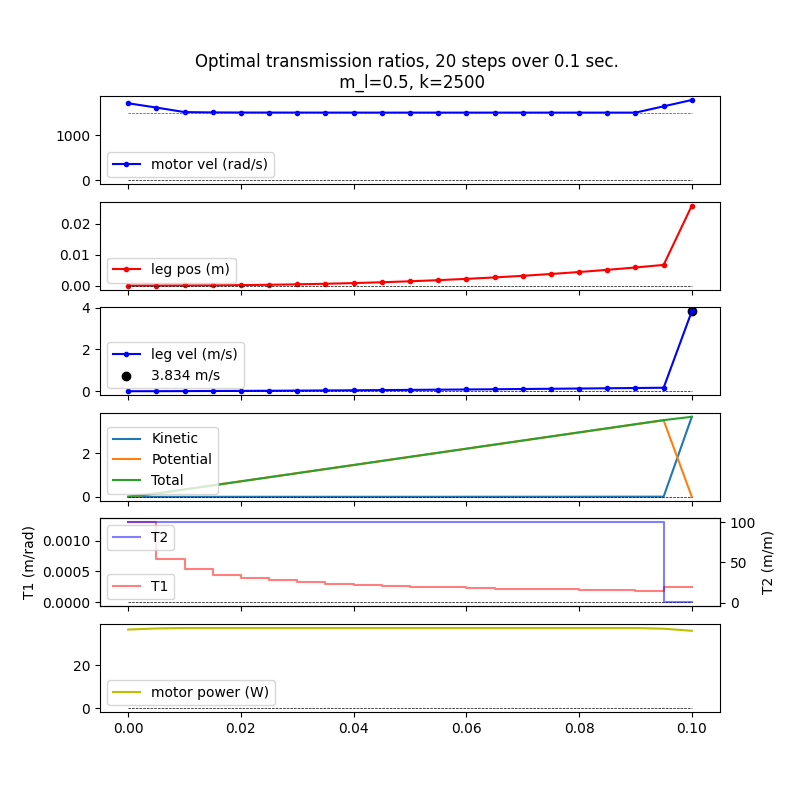

In [4]:
T1_bound = [1e-6, 0.002]
T2_bound = [1e-6, 100]
k_bound = [2499.5, 2500.4]

X_init = [0,0,0]
T1_guess = np.random.uniform(T1_bound[0], T1_bound[1], nsteps)
T2_guess = np.random.uniform(T2_bound[0], T2_bound[1], nsteps)
T_guess = np.array([T1_guess, T2_guess])
k_guess = 300

sol, X_opt, k_opt = opti_steps(nsteps, t, X_init, T_guess, k_guess, T1_bound, T2_bound, k_bound, leg_max)

ts = np.linspace(0, t_total, nsteps+1)
x_as = X_opt[0,:]
v_as = np.gradient(x_as, ts)
x_ls_adj = X_opt[1,:]
v_ls = X_opt[2,:]
x_ls = np.cumsum(v_ls) * t
T1s = X_opt[3,:]
T2s = X_opt[4,:]

KE = (1/2)*m_l*v_ls**2
PE = (1/2)*k_opt*(x_as*T1s - x_ls_adj/T2s)**2
motor_powers = tau_max*v_as*(1 - v_as/omega_max)
E_motor = np.cumsum(motor_powers) * t

# plt.close('all')
fig, axs = plt.subplots(6, 1, sharex=True, figsize=(8,8))
ts = np.linspace(0, t_total, nsteps+1)

axs[0].set_title(f"Optimal transmission ratios, {nsteps} steps over {round(t_total, 2)} sec. \n m_l={m_l}, k={round(k_opt)}")

axs[0].plot(ts, v_as, 'b.-', label='motor vel (rad/s)')
axs[0].plot(ts, np.full(ts.shape, omega_max/2), 'g--', linewidth=0.5)

axs[1].plot(ts, x_ls, 'r.-', label='leg pos (m)')
# axs[1].plot(ts, x_ls_adj, 'r.-', label='leg pos adj (m)')

axs[2].plot(ts, v_ls, 'b.-', label='leg vel (m/s)')
axs[2].scatter(ts[-1], v_ls[-1], c='black', label=f"{round(v_ls[-1],3)} m/s")

axs[3].plot(ts, KE, label='Kinetic')
axs[3].plot(ts, PE, label='Potential')
axs[3].plot(ts, KE+PE, label='Total')
# axs[3].plot(ts, E_motor, label='Motor')

axs[4].step(ts, T1s, label='T1', color='red', alpha=0.5)
axs[4].set_ylabel('T1 (m/rad)')
axs_twin = axs[4].twinx()
axs_twin.step(ts, T2s, label='T2', color='blue', alpha=0.5)
axs_twin.set_ylabel('T2 (m/m)')
axs_twin.legend()

print(k_opt)

axs[5].plot(ts, motor_powers, 'y-', label='motor power (W)')

for ax in axs:
    ax.plot(ts, np.zeros_like(ts), 'k--', linewidth=0.5)
    ax.legend(loc='lower left')
plt.show()

np.savetxt(f'saved_opts3/Xopt_v{round(v_ls[-1]*1000)}_k{round(k_opt)}_m{round(m_l*1000)}_t{round(t_total*1000)}_L{round(leg_max*1000)}.txt', X_opt)



In [5]:
def plot_X(X_opt, k_opt):
    ts = np.linspace(0, t_total, nsteps+1)
    x_as = X_opt[0,:]
    v_as = np.gradient(x_as, ts)
    x_ls_adj = X_opt[1,:]
    v_ls = X_opt[2,:]
    x_ls = np.cumsum(v_ls) * t
    T1s = X_opt[3,:]
    T2s = X_opt[4,:]

    KE = (1/2)*m_l*v_ls**2
    PE = (1/2)*k_opt*(x_as*T1s - x_ls_adj/T2s)**2
    motor_powers = tau_max*v_as*(1 - v_as/omega_max)
    E_motor = np.cumsum(motor_powers) * t

    # plt.close('all')
    fig, axs = plt.subplots(6, 1, sharex=True, figsize=(8,8))
    ts = np.linspace(0, t_total, nsteps+1)

    axs[0].set_title(f"Optimal transmission ratios, {nsteps} steps over {round(t_total, 2)} sec. \n m_l={m_l}, k={round(k_opt)}")

    axs[0].plot(ts, v_as, 'b.-', label='motor vel (rad/s)')
    axs[0].plot(ts, np.full(ts.shape, omega_max/2), 'g--', linewidth=0.5)

    axs[1].plot(ts, x_ls, 'r.-', label='leg pos (m)')
    # axs[1].set_ylim(-0.01, 0.11)
    # axs[1].plot(ts, x_ls_adj, 'r.-', label='leg pos adj (m)')

    axs[2].plot(ts, v_ls, 'b.-', label='leg vel (m/s)')
    axs[2].scatter(ts[-1], v_ls[-1], c='black', label=f"{round(v_ls[-1],3)} m/s")

    axs[3].plot(ts, KE, label='Kinetic')
    axs[3].plot(ts, PE, label='Potential')
    axs[3].plot(ts, KE+PE, label='Total')
    # axs[3].plot(ts, E_motor, label='Motor')

    axs[4].step(ts, T1s, label='T1', color='red', alpha=0.5)
    axs[4].set_ylabel('T1 (m/rad)')
    axs_twin = axs[4].twinx()
    axs_twin.step(ts, T2s, label='T2', color='blue', alpha=0.5)
    axs_twin.set_ylabel('T2 (m/m)')
    axs_twin.legend(loc='upper right')

    axs[5].plot(ts, motor_powers, 'y-', label='motor power (W)')

    for ax in axs:
        ax.plot(ts, np.zeros_like(ts), 'k--', linewidth=0.5)
        ax.legend(loc='lower left')
    plt.show()

In [11]:
trials = 20

lhc = qmc.LatinHypercube(d=2*nsteps+1)
lhc_samp = lhc.random(n=trials)
T1_bound = [1e-6, 0.002]
T2_bound = [1e-6, 100]
k_bound = [2499.5, 2501.4]
X_init = [0,0,0]

folder_name = f'saved_opts_k{round(k_bound[0])}_m{round(m_l*1000)}_t{round(t_total*1000)}_L{round(leg_max*1000)}'
os.makedirs(folder_name, exist_ok=True)

successes = 0
fails = 0
for i in range(trials):
    print(f"[{i}]", end='')
    try:
        T1_guess = lhc_samp[i,:nsteps]*(T1_bound[1] - T1_bound[0]) + T1_bound[0]
        T2_guess = lhc_samp[i,nsteps:2*nsteps]*(T2_bound[1] - T2_bound[0]) + T2_bound[0]
        k_guess = lhc_samp[i,2*nsteps]*(k_bound[1] - k_bound[0]) + k_bound[0]
        T_guess = np.array([T1_guess, T2_guess])

        sol, X_opt, k_opt = opti_steps(nsteps, t, X_init, T_guess, k_guess, T1_bound, T2_bound, k_bound, leg_max)
        end_v = X_opt[2,-1]

        np.savetxt(f'{folder_name}/Xopt_v{round(end_v*1000)}_k{round(k_opt)}_m{round(m_l*1000)}_t{round(t_total*1000)}_L{round(leg_max*1000)}.txt', X_opt)
        successes += 1
    except Exception as e:
        fails += 1

print(f"successes: {successes}, fails: {fails}")

[0][1][2][3][4][5][6][7][8][9][10][11][12][13][14][15][16][17][18][19]successes: 19, fails: 1


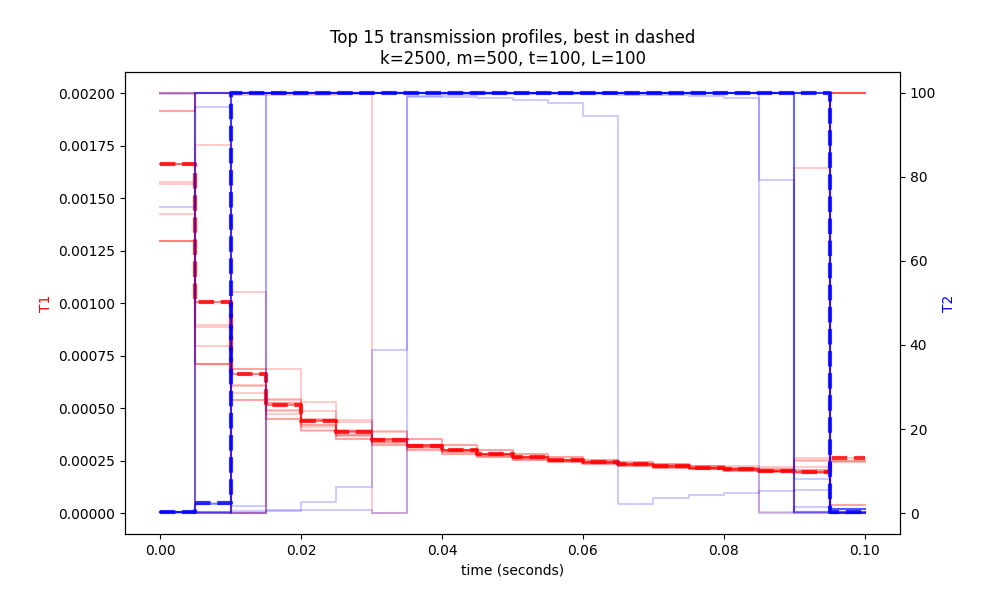

In [20]:
axs = [0,0]
fig, axs[0] = plt.subplots(1,1, figsize=(10,6))
ax0_twin = axs[0].twinx()
folder = folder_name
k_folder = int(folder.split("_")[2].split("k")[1])
m_folder = int(folder.split("_")[3].split("m")[1])
t_folder = int(folder.split("_")[4].split("t")[1])
L_folder = int(folder.split("_")[5].split("L")[1])

v_max = 0
topN = 15
for file in sorted(os.listdir(folder))[-topN:]:
    if(not file.endswith(".txt")):
        continue

    X_optload = np.loadtxt(f'{folder}/{file}')
    file = file[:-4] #remove '.txt'
    v_file = round(int(file.split("_")[1].split("v")[1]) * 0.001, 3)
    k_file = int(file.split("_")[2].split("k")[1])
    m_file = int(file.split("_")[3].split("m")[1])
    t_file = int(file.split("_")[4].split("t")[1])
    L_file = int(file.split("_")[5].split("L")[1])
    
    if(v_file > v_max):
        v_max = v_file
        X_best = X_optload

    ts = np.linspace(0, t_total, nsteps+1)
    axs[0].step(ts, X_optload[3], 'r', alpha=0.2)
    ax0_twin.step(ts, X_optload[4], 'b', alpha=0.2)

axs[0].step(ts, X_best[3], 'r--', label=f"best", alpha=0.8, linewidth=3)
ax0_twin.step(ts, X_best[4], 'b--', label=f"best", alpha=0.8, linewidth=3)
# ax0_twin.set_ylim(0, 20)
axs[0].set_xlabel('time (seconds)')
axs[0].set_ylabel('T1', color='red')
ax0_twin.set_ylabel('T2', color='blue')

plt.title(f"Top {topN} transmission profiles, best in dashed\nk={k_folder}, m={m_folder}, t={t_folder}, L={L_folder}")
plt.savefig(f'{folder}/figure2.png', dpi=300)
plt.show()

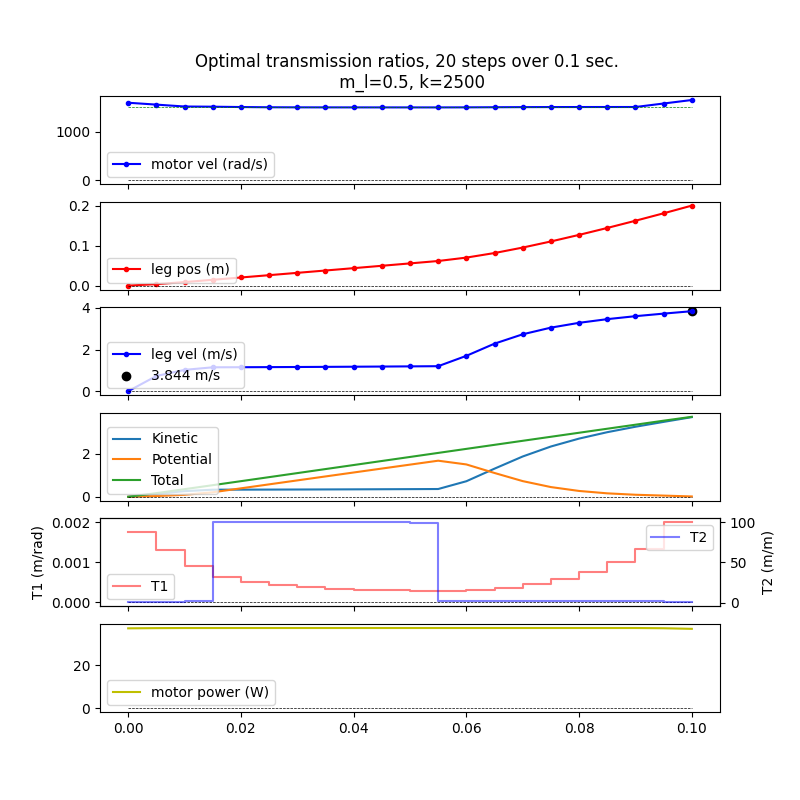

In [177]:
plot_X(X_best, 2500)

In [89]:
#load profile and test modifications
X_opt = np.loadtxt("saved_opts2/Xopt_v5146_k950.txt")
k_opt = 950

plot_X(X_opt, k_opt) #plot original

#make adjustment and replot
Ts = X_opt[3:,1:] #choose T1 and T2, remove first index
Ts[1,0] = 99
Ts[1,-3] = 1
Ts[1,-2] = 1

X0 = X_opt[:,0]
X0[3] = Ts[0,0]
X0[4] = Ts[1,0]
X_test = Fstep_n(X0, Ts, k_opt).toarray()

X_test = np.insert(X_test, 0, X0, axis=1)

plot_X(X_test, k_opt)

FileNotFoundError: saved_opts2/Xopt_v5146_k950.txt not found.